# 2D Toy Problems
- 2D Heat equation dense solver
- 2D Heat equation sparse solver
- 2D Advection, periodic bc
- 2D Advec-Diffusion zero bc

Ref: https://hplgit.github.io/fdm-book/doc/pub/book/pdf/fdm-book-4screen.pdf
<br>
<br>
<br>

- The Actual system???

It's all just matrices. Try rewriting 1D code so it is clearer how we are solving a matrix system. About 4 times quicker!

In [88]:
block = lambda x: np.array([float(i>=4 and i<=6) for i in x])
block2 = lambda x: np.array([int(i>=4 and i<=6) for i in x])
x = np.linspace(0,10,100)
np.all(block(x) == block2(x))

True

2.71875


C:\Users\s1415551\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:139: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


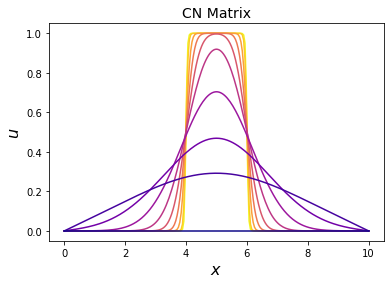

In [279]:
#!/usr/bin/env python
# As v1, but using scipy.sparse.diags instead of spdiags
"""
Functions for solving a 1D diffusion equations of simplest types
(constant coefficient, no source term):

      u_t = a*u_xx on (0,L)

with boundary conditions u=0 on x=0,L, for t in (0,T].
Initial condition: u(x,0)=I(x).

The following naming convention of variables are used.

===== ==========================================================
Name  Description
===== ==========================================================
Nx    The total number of mesh cells; mesh points are numbered
      from 0 to Nx.
F     The dimensionless number a*dt/dx**2, which implicitly
      specifies the time step.
T     The stop time for the simulation.
I     Initial condition (Python function of x).
a     Variable coefficient (constant).
L     Length of the domain ([0,L]).
x     Mesh points in space.
t     Mesh points in time.
n     Index counter in time.
u     Unknown at current/new time level.
u_n   u at the previous time level.
dx    Constant mesh spacing in x.
dt    Constant mesh spacing in t.
===== ==========================================================

user_action is a function of (u, x, t, n), u[i] is the solution at
spatial mesh point x[i] at time t[n], where the calling code
can add visualization, error computations, data analysis,
store solutions, etc.
"""
import sys, time
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
import numpy as np

def solver_theta(I, a, f, L, dt, F, T, theta=0.5, u_L=0, u_R=0,
                 user_action=None):
    """
    Full solver for the model problem using the theta-rule
    difference approximation in time (no restriction on F,
    i.e., the time step when theta >= 0.5).
    Vectorized implementation and sparse (tridiagonal)
    coefficient matrix.
    """
    import time;  t0 = time.process_time() # for measuring the CPU time
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    U = np.zeros((Nt+1,Nx+1))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    u   = np.zeros(Nx+1)   # solution array at t[n+1]
    u_n = np.zeros(Nx+1)   # solution at t[n]

    # Representation of sparse matrix and right-hand side
    diagonal = np.zeros(Nx+1)
    lower    = np.zeros(Nx)
    upper    = np.zeros(Nx)
    b        = np.zeros(Nx+1)

    # Precompute sparse matrix (scipy format)
    Fl = F*theta
    Fr = F*(1-theta)
    diagonal[:] = 1 + 2*Fl
    lower[:] = -Fl  #1
    upper[:] = -Fl  #1
    # Insert boundary conditions
    diagonal[0] = 1
    upper[0] = 0
    diagonal[Nx] = 1
    lower[-1] = 0

    diags = [0, -1, 1]
    A = scipy.sparse.diags(
        diagonals=[diagonal, lower, upper],
        offsets=[0, -1, 1], shape=(Nx+1, Nx+1),
        format='csr')
    #print A.todense()

    # Set initial condition
    
    u_n = I(x)
    U[0,] = u_n

    # Time loop
    for n in range(0, Nt):
        b[1:-1] = u_n[1:-1] + \
                  Fr*(u_n[:-2] - 2*u_n[1:-1] + u_n[2:]) 
        b[0] = u_L; b[-1] = u_R  # boundary conditions
        u[:] = scipy.sparse.linalg.spsolve(A, b)

        # Update u_n before next step
        u_n, u = u, u_n
        U[n,] = u
    
    t1 = time.process_time()
    print(t1-t0)
    return x, U
block = lambda x: np.array([float(i>=4 and i<=6) for i in x])
gaussian = lambda x: stats.norm.pdf(x, loc=5, scale=1) 
def bump(x,a):
    f = np.zeros(len(x))
    for i in range(len(x)):
        if a <= np.abs(x[i]) <= a+0.025:
            f[i] = np.exp(1/(x[i]**2-(a+1)**2))/np.exp(1/(a**2-(a+1)**2))
        elif np.abs(x[i]) < a:
            f[i] = 1
        else:
            f[i] = 0
    return f

initial_data =block # lambda x: bump(x-5,1)

x, sol = solver_theta(I=initial_data, a=1, f=(lambda x,t: 0), L=10, dt=0.001, F=0.5, T=10, theta=0.5, u_L=0, u_R=0,
                 user_action=None)
colormap = plt.get_cmap('plasma')
fig, ax = plt.subplots()
ax.set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
ax.set_title('CN Matrix', fontsize=14)
ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$u$', fontsize=16)

for i in np.logspace(0, np.log10(len(sol[:,0])-1), num=10):
    ax.plot(x, sol[int(i),])

fig.show()

In [1]:
%matplotlib qt

import scipy.sparse
import scipy.sparse.linalg
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

def CN(U,U1, D, dt, dx, Nt, Nx):
    mu = D*dt/(dx**2)
    upper = -(0.5 * mu)*np.ones(Nx)
    main = (1 + mu)*np.ones(Nx+1)
    main[0] = 1
    main[Nx] = 1
    lower = -(0.5 * mu)*np.ones(Nx)
    upper[0] = 0
    lower[-1] = 0
    diagonals = [lower, main, upper]
    A = scipy.sparse.diags(diagonals, offsets=[-1, 0 ,1], shape=(Nx+1,Nx+1), format="csr")
    
    b = np.zeros(Nx+1)
    c = np.zeros(Nx+1)
    _a = -(0.5 * mu)*np.ones(Nx+1)
    _b = main
    _c = -(0.5 * mu)*np.ones(Nx+1)
    _d, _e, _f = [np.zeros(Nx+1) for _ in range(3)]
    
    
    # Build arrays of new coefficients
    for n in range(0, Nt):
        u = U[n,]
        u_plus_one = np.roll(u,1)
        u_minus_one = np.roll(u,-1)
        flux_right =-0.5 *D* (u_plus_one - u)/dx
        flux_left = -0.5*D* (u - u_minus_one)/dx #np.roll(flux_right,1)

        c = u + (flux_left-flux_right)*(dt/dx)
        c[0] = 0
        c[-1] = 0
        b[1:-1] = U[n,1:-1] + 0.5*mu * (U[n, 2:] - 2*U[n, 1:-1] + U[n, :-2])
        b[0] = 0
        b[-1] = 0 
        
                #Build tridiagonal matrix
#         _d = np.copy(b)
#         _e = _c/(_b - _a*np.roll(_e,1))
#         _f = (_d + _a*np.roll(_f,1)) / (_b - _a*np.roll(_e,1))

        #Solve system
        U1[n+1, 1:-1] = _f[1:-1] + _e[1:-1]*U1[n+1, 0:-2]
        U1[n+1,0] = 0
        U1[n+1,-1] = 0
        U[n+1,] = scipy.sparse.linalg.spsolve(A,b)

        U1[n+1,] = scipy.sparse.linalg.spsolve(A,c)
    return U,U1


def solve_heat_eqn(solver=CN, D=1, dt=0.01, dx=0.1, T_end=5, L=5,
            initial_dist=(lambda x: stats.norm.pdf(x, loc=0, scale=1))):

    Nt = int(T_end/dt)
    Nx = int(2*L/dx)
    t = np.linspace(0, T_end, Nt+1)
    x = np.linspace(-L, L, Nx+1)
    dt = t[1]-t[0]
    dx = x[1] - x[0]
    U = np.zeros((Nt+1, Nx+1), dtype= float)

    U_0 = initial_dist(x)  #Initial Conditions
    U[0,] = U_0
    U1 = np.copy(U)
    sol,sol1 = solver(U, U1, D, dt, dx, Nt, Nx)

    return x, sol,sol1

def bump(x,a):
    f = np.zeros(len(x))
    for i in range(len(x)):
        if a <= np.abs(x[i]) <= a+0.2:
            f[i] = np.exp(1/(x[i]**2-(a+1)**2))/np.exp(1/(a**2-(a+1)**2))
        elif np.abs(x[i]) < a:
            f[i] = 1.
        else:
            f[i] = 0.
    return f
gaussian = (lambda x: stats.norm.pdf(x, loc=0, scale=1))
#(lambda x: bump(x+2.5,1))
block = lambda x: np.array([float(i>=0 and i<=1) for i in x])
initial_data = (lambda x: bump(x+2.5,1))


x, sol,sol1 = solve_heat_eqn(D=1, dt=0.005,dx=0.1, T_end=50, initial_dist=initial_data)

colormap = plt.get_cmap('plasma')
fig, ax = plt.subplots(1,2)
ax[0].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
ax[1].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
#fig.set_sup_title('CN Matrix', fontsize=14)
ax[0].set_xlabel(r'TDMA', fontsize=16)
ax[1].set_xlabel(r'spsolve', fontsize=16)
for i in np.logspace(0, np.log10(len(sol[:,0])-1), num=10):
    ax[0].plot(x, sol1[int(i),])
    ax[1].plot(x, sol[int(i),])


fig.show()

## Advection-Diffusion Equation 
Matrix style.

$$u_t + au_x =\sigma u_{xx}$$
$$u'(t) = Au(t)$$


In [33]:
N=10
main = np.zeros(N)
main[:] = 1
print(main)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [2]:
def solve_adv_diff_eqn(adv_solver='first_order_upwind', a=1, D=1, dt=0.001, dx=0.1, T_end=5, L=5,
                initial_dist=(lambda x: stats.norm.pdf(x, loc=0, scale=1))):

    Nt = int(T_end/dt)
    Nx = int(2*L/dx)
    t = np.linspace(0, T_end, Nt+1)
    x = np.linspace(-L, L , Nx+1)


    U = np.zeros((Nt+1, Nx+1), dtype= float)

    U_0 = initial_dist(x) #Initial Conditions
    U[0,] = U_0

    mu = D*dt/(dx)**2
    #TODO: Error in the matrix here? mu == 0. This should be fine, scheme is explicit?
    upper= -(0.5*mu)*np.ones(Nx)
    main = (1 + mu)*np.ones(Nx+1)
    lower= -(0.5*mu)*np.ones(Nx)
    main[0] = 1
    main[Nx] = 1
    upper[0] = 1
    lower[-1] = 0
    diagonals = [lower, main, upper]
    A = scipy.sparse.diags(diagonals, offsets=[-1,0,1], format="csr")
    b = np.zeros(Nx+1)
    
    def psi_1(theta): return 0.0#np.zeros(len(theta))
    def psi_2(theta): return float(1/2)#*np.ones(len(theta))
    def psi_3(theta): return  (1/3 + (1/6)*theta)
    def psi_flux(theta): return (np.maximum(0,np.minimum(np.minimum(1, 1/3 + (1/6)*theta), theta)))
    def psi_vl(theta): return (0.5*(theta+np.abs(theta))/(1+np.abs(theta)))

    solvers = {'first_order_upwind': psi_1,
               'second_order_upwind': psi_2,
               'third_order_upwind': psi_3,
               'flux_limited_upwind': psi_flux,
               'van_Leer': psi_vl,
              }

    psi = solvers[str(adv_solver)]
    eps = 10**-25
    
    c = a * (dt/dx)
    if abs(c)>1:
        warnings.warn('Method is likely to be unstable, CFL condition failed, c={}>1'.format(c))
    if mu> 1/2:
        warnings.warn(r'Method is likely to be unstable, von Neumann condition failed, \mu ={}>1/2'.format(mu))
    for n in range(Nt):
        #b[0] = 0
        # Interior
        u = U[n,]
        u_minus_one = np.roll(u,1)
        u_plus_one = np.roll(u, -1)

        theta_r = (u - u_minus_one) / (u_plus_one - u +eps)
        theta_r_plus_one = np.roll(theta_r, -1)
        neg_wave_r = (u_plus_one + psi(1/(theta_r_plus_one+eps))*(u - u_plus_one))
        pos_wave_r = (u +  psi(theta_r)*(u_plus_one - u)) 
        
        adv_right = min(a,0)*neg_wave_r + max(a,0)*pos_wave_r
        diff_right = - 0.5*D* (u_plus_one - u)/dx
        flux_right = adv_right + diff_right
        
        flux_left = np.roll(flux_right,1) 
        b = u +  (dt/dx)*(flux_left - flux_right)
        b[0] =  0
        b[-1] = 0
        U[n+1,] = scipy.sparse.linalg.spsolve(A,b)
        
    mass_loss =  (1 - sum(U[-1,:])/sum(U[0,:]))*100
    print('{} mass loss was {:.5f}%'.format(adv_solver, mass_loss))
    return x, U


In [1]:
%%timeit
%matplotlib inline
import warnings
wavespeed = -1
diffusion = 0
T_final = 5
length = 10

def gaussian(x): return stats.norm.pdf(x, loc=2, scale=1)
def block(x): return np.array([float(i>=-0.5 and i<=0.5) for i in x])
def bump(x,a):
    f = np.zeros(len(x))
    for i in range(len(x)):
        if a <= np.abs(x[i]) <= a+1:
            f[i] = np.exp(1/(x[i]**2-(a+1)**2))/np.exp(1/(a**2-(a+1)**2))
        elif np.abs(x[i]) < a:
            f[i] = 1
        else:
            f[i] = 0
    return f

initial_data = block #gaussian # lambda x: bump(x, 0.8)
#'second_order_upwind','third_order_upwind', 
adv_solvers = ['flux_limited_upwind', 'van_Leer','first_order_upwind','third_order_upwind']#,'second_order_upwind']


colormap = plt.get_cmap('plasma')
fig, ax = plt.subplots(len(adv_solvers), 1, figsize=(10,20))
fig.suptitle(r'Solving  $u_t+au_x = \sigma  d^2 u/dx^2$, a={}, \sigma ={},'.format(wavespeed,diffusion), fontsize=16)
err_fig, err_ax= plt.subplots()
if len(adv_solvers) == 1:
    ax = [ax]
for idx, solver in enumerate(adv_solvers):
    adv_x, adv_sol = solve_adv_diff_eqn(adv_solver=solver, a=wavespeed, D=diffusion, T_end=T_final, dx=0.1, dt=0.05, L=length, initial_dist=initial_data)
    ax[idx].set_title(solver, fontsize=14)
    ax[idx].set_xlabel(r'$x$', fontsize=14)
    ax[idx].set_ylabel(r'$u$', fontsize=14)
    ax[idx].set_prop_cycle(color=[colormap(k) for k in np.linspace(1, 0, 10)])
    for i in np.logspace(0, np.log10(np.size(adv_sol, axis=0)-1), num=10):
        ax[idx].plot(adv_x, adv_sol[int(i),])
        ax[idx].plot(adv_x, initial_data(adv_x-wavespeed*T_final), 'k--', alpha=0.05)
    true_sol = initial_data(adv_x-wavespeed*T_final)
    err_ax.plot(adv_x, np.cumsum((true_sol - adv_sol[-1,])**2)**(1/2), label=' {} Error'.format(solver))
    err_ax.legend()

err_fig.suptitle(r'$l_2$ Error in Solvers')
err_fig.show()    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.6)
fig.show()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


savepath = './'
#Uncomment to save in parent directory
plt.savefig(savepath+'{}.jpg'.format('upwind'), format='jpg', dpi=1000)
plt.show()


NameError: name 'plt' is not defined

## 2D Diffusion Equation
Looking to solve the 2D Heat equation with constant diffusion coefficient, first with FD then try convert to FV.
$$ u_t = D[u_{xx} + u_{yy}] =  \nabla \cdot \nabla (Du) $$
How can we do this? Following the reference above, discretise in space and produce ODE system, then step in time. We now have two dimensions, so instead of a system with $N+1$ unknowns, we will have $N_x+1 \times N_y+1)$. To account for this, we must have a mapping from $\mathbb{R}^2 \to \mathbb{R}$ so that all unknowns fit into one vector. This mapping will me given by 
$$ p = m(i,j) = j \times (N_x+1) + i$$

Discretisation in space is done using centered differences and in time will be Crank-Nicholson. Most of the faff is in actually setting up the system, discretising and solving is very similar to before (TODO: rewrite the old stuff so that it looks even more similar)

### Dense Implementation


In [ ]:
import numpy as np
def solve_2d_heat_dense(initial=(lambda x,y: 1), D=1, Lx=1, Ly=1, dx=0.2, dy=0.2, dt=0.1, T_final=0.5, U_0x=(lambda x: 0), U_0y=(lambda x: 0), U_Lx=(lambda x: 0), U_Ly=(lambda x : 0)):
    # does this setup allow for periodic BC? could maybe change so that it takes in keyword 'periodic' or 'zero'
    
    # Mesh space
    Nt = int(T_end/dt)
    t = np.linspace(0, T_end, Nt+1)
    Nx = int(2*Lx/dx)
    Ny = int(2*Ly/dy)
    x = np.linspace(-Lx, Lx, Nx+1)
    y = np.linspace(-Ly, Ly, Ny+1)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    

    mu_x = D*dt/dx**2  # Change when moving to finite volume
    mu_y = D*dt/dy**2
    # Solution storage - note only stores two timesteps. More than that is too big! 
    #TODO: change plotting, add plotting variable
    U = np.zeros((Nx+1, Ny+1))
    U_n = np.zeros((Nx+1, Ny+1))
    
    # Creat indices in each dimension makes things more readable
    Ix = range(0, Nx+1)
    Iy = range(0, Ny+1)
    It = range(0,Nt+1)

        
    # Initial condition into U_n
    for i in Ix:
        for j in Iy:
            U_n[i,j] = initial(x[i], y[j])      
        
    # Data structures for the linear system
    N = (Nx+1)*(Ny+1)  # no of unknowns 
    A = np.zeros((N, N))
    b = np.zeros(N)
    
    # Define our mapping from 2d -> 1d
    m = lambda i,j: j*(Nx+1) + i
    
    # Starting from bottom boundary, fill in the matrix A
    j = 0
    for i in Ix:
        p = m(i,j)
        A[p,p] = 1
    # Now loop over interior points
    for j in Iy[1:-1]: # First and last given by bdy
        i = 0
        p = m(i,j)
        A[p,p] = 1 # left bdy 
        for i in Ix[1:-1]:
            p = m(i,j)
            A[p, m(i, j-1)] = -0.5*mu_y
            A[p, m(i-1, j)] = -0.5*mu_x
            A[p,p] = 1 + (mu_x+mu_y)
            A[p, m(i+1, j)] = -0.5*mu_x
            A[p, m(i, j+1)] = -0.5*mu_y
        i = Nx
        p = m(i,j)
        A[p,p] = 1 # right bdy
    j = Ny
    for i in Ix:
        p = m(i,j)
        A[p,p] = 1 # top bdy
    
    
    # So matrix A is built. It stays constant, just need to change b at each time step.
    # Discretising in time
    import scipy.linalg
    for n in It[:-1]:
        j = 0
        for i in Ix:
            p = m(i,j)
            b[p] = U_0y(t[n+1]) # bottom bdy
        for j in Iy[1:-1]:
            i = 0 # left bdy
            p = m(i,j)
            b[p] = U_0x(t[n+1])
            for i in Ix[1:-1]:
                p = m(i,j)
                # Interior points
                x_dir =  0.5 * (mu_x*(U_n[i+1,j] - 2*U_n[i,j] + U_n[i-1,j]))
                y_dir = 0.5 * (mu_y*(U_n[i,j+1] - 2*U_n[i,j] + U_n[i,j-1]))
                # Put together
                b[p] = U_n[i,j] + x_dir + y_dir
            i = Nx
            p = m(i,j)
            b[p] = U_Lx(t[n+1]) #right bdy
        j = Ny
        for i in Ix:
            p = m(i,j)
            b[p] = U_Ly(t[n+1]) # top bdy
        
        c = scipy.linalg.solve(A,b)
        U[:,:] =  c.reshape(Ny+1,Nx+1).T

        # Update ready for next step
        U_n, U = U, U_n

    return t, U
    

In [ ]:
import numpy as np
def solve_2d_heat_dense(initial=(lambda x,y: 1), D=1, Lx=1, Ly=1, Nx=10, Ny=10, dt=0.1, T_final=0.5, theta=0.5, U_0x=(lambda x: 0), U_0y=(lambda x: 0), U_Lx=(lambda x: 0), U_Ly=(lambda x : 0), plot =True):
    # does this setup allow for periodic BC? could maybe change so that it takes in keyword 'periodic' or 'zero'
    
    # Mesh space
    x = np.linspace(0, Lx, Nx+1)
    y = np.linspace(0, Ly, Ny+1)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    # Mesh time
    dt = float(dt)
    Nt = int(round(T_final/dt))
    t = np.linspace(0,Nt*dt, Nt+1)
    
    # Fourier numbers
    Fx = D*dt/dx**2  # Change when moving to finite volume
    Fy = D*dt/dy**2
    # Solution storage - note only stores two timesteps. More than that is too big! 
    #TODO: change plotting, add plotting variable
    u = np.zeros((Nx+1, Ny+1))
    u_n = np.zeros((Nx+1, Ny+1))
    
    # Creat indices in each dimension makes things more readable
    Ix = range(0, Nx+1)
    Iy = range(0, Ny+1)
    It = range(0,Nt+1)

        
    # Initial condition into u_n
    for i in Ix:
        for j in Iy:
            u_n[i,j] = initial(x[i], y[j])      
        
    # Data structures for the linear system
    N = (Nx+1)*(Ny+1)  # no of unknowns 
    A = np.zeros((N, N))
    b = np.zeros(N)
    
    # Define our mapping from 2d -> 1d
    m = lambda i,j: j*(Nx+1) + i
    
    # Starting from bottom boundary, fill in the matrix A
    j = 0
    for i in Ix:
        p = m(i,j)
        A[p,p] = 1
    # Now loop over interior points
    for j in Iy[1:-1]: # First and last given by bdy
        i = 0
        p = m(i,j)
        A[p,p] = 1 # left bdy 
        for i in Ix[1:-1]:
            p = m(i,j)
            A[p, m(i, j-1)] = -theta*Fy
            A[p, m(i-1, j)] = -theta*Fx
            A[p,p] = 1 + 2*theta*(Fx+Fy)
            A[p, m(i+1, j)] = -theta*Fx
            A[p, m(i, j+1)] = -theta*Fy
        i = Nx
        p = m(i,j)
        A[p,p] = 1 # right bdy
    j = Ny
    for i in Ix:
        p = m(i,j)
        A[p,p] = 1 # top bdy
    
    
    # So matrix A is built. It stays constant, just need to change b at each time step.
    # Discretising in time
    import scipy.linalg
    for n in It[:-1]:
        j = 0
        for i in Ix:
            p = m(i,j)
            b[p] = U_0y(t[n+1]) # bottom bdy
        for j in Iy[1:-1]:
            i = 0 # left bdy
            p = m(i,j)
            b[p] = U_0x(t[n+1])
            for i in Ix[1:-1]:
                p = m(i,j)
                # Interior points
                x_dir = (1-theta) * (Fx*(u_n[i+1,j] - 2*u_n[i,j] + u_n[i-1,j]))
                y_dir = (1-theta) * (Fy*(u_n[i,j+1] - 2*u_n[i,j] + u_n[i,j-1]))
                # Put together
                b[p] = u_n[i,j] + x_dir + y_dir
            i = Nx
            p = m(i,j)
            b[p] = U_Lx(t[n+1]) #right bdy
        j = Ny
        for i in Ix:
            p = m(i,j)
            b[p] = U_Ly(t[n+1]) # top bdy
        
        c = scipy.linalg.solve(A,b)
        u[:,:] =  c.reshape(Ny+1,Nx+1).T

        # Update ready for next step
        u_n, u = u, u_n

    return t, u
    

Running and plotting the final timestep. change code so that it plots new surface every 10? steps. 
if n % 10: plot? Need more adaptive method if plotting many.

Or could store so many points? Then animate after.

Or just don't waste time doing it here and do it for the sparse implementation where everything will be quicker.

In [ ]:
%matplotlib qt
x_len = 1
y_len = 1
x_step = 0.1
y_step = 0.1
x_points = int(2*x_len/x_step)
y_points = int(2*y_len/y_step)
diffusion = 1
T_end = 0.2
timestep = 0.01

t, u = solve_2d_heat_dense(Lx=x_len,Ly=y_len, dx=x_step, dy=y_step, D=diffusion,T_final=T_end)

X = np.linspace(-x_len, x_len, x_points+1)
Y = np.linspace(-y_len, y_len, y_points+1)
print(X.shape, Y.shape, u.shape)
X, Y = np.meshgrid(X, Y)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X,Y,u)
fig.show()

In [ ]:
import scipy.sparse
import scipy.sparse.linalg
import numpy as np
def solve_2d_heat_sparse(
    initial, a, Lx, Ly, Nx, Ny, dt, T, theta=0.5,
    U_0x=0, U_0y=0, U_Lx=0, U_Ly=0):
    """
    Full solver for the model problem using the theta-rule
    difference approximation in time. Sparse matrix with
    dedicated Gaussian elimination algorithm 
    """
    x = np.linspace(0, Lx, Nx+1)       # mesh points in x dir
    y = np.linspace(0, Ly, Ny+1)       # mesh points in y dir
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    dt = float(dt)                  # avoid integer division
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt+1) # mesh points in time

    # Mesh Fourier numbers in each direction
    Fx = a*dt/dx**2
    Fy = a*dt/dy**2
    
    u   = np.zeros((Nx+1, Ny+1))    # unknown u at new time level
    u_n = np.zeros((Nx+1, Ny+1))    # u at the previous time level

    Ix = range(0, Nx+1)
    Iy = range(0, Ny+1)
    It = range(0, Nt+1)

    # Make U_0x, U_0y, U_Lx and U_Ly functions if they are float/int
    if isinstance(U_0x, (float,int)):
        _U_0x = float(U_0x)  # Make copy of U_0x
        U_0x = lambda t: _U_0x
    if isinstance(U_0y, (float,int)):
        _U_0y = float(U_0y)  # Make copy of U_0y
        U_0y = lambda t: _U_0y
    if isinstance(U_Lx, (float,int)):
        _U_Lx = float(U_Lx)  # Make copy of U_Lx
        U_Lx = lambda t: _U_Lx
    if isinstance(U_Ly, (float,int)):
        _U_Ly = float(U_Ly)  # Make copy of U_Ly
        U_Ly = lambda t: _U_Ly

    # Load initial condition into u_n
    for i in Ix:
        for j in Iy:
            u_n[i,j] = initial(x[i], y[j])


    N = (Nx+1)*(Ny+1)
    main   = np.zeros(N)            # diagonal
    lower  = np.zeros(N-1)          # subdiagonal
    upper  = np.zeros(N-1)          # superdiagonal
    lower2 = np.zeros(N-(Nx+1))     # lower diagonal
    upper2 = np.zeros(N-(Nx+1))     # upper diagonal
    b      = np.zeros(N)            # right-hand side

    # Precompute sparse matrix
    lower_offset = 1
    lower2_offset = Nx+1

    m = lambda i, j: j*(Nx+1) + i
    j = 0; main[m(0,j):m(Nx+1,j)] = 1  # j=0 boundary line
    for j in Iy[1:-1]:             # Interior mesh lines j=1,...,Ny-1
        i = 0;   main[m(i,j)] = 1  # Boundary
        i = Nx;  main[m(i,j)] = 1  # Boundary
        # Interior i points: i=1,...,N_x-1
        lower2[m(1,j)-lower2_offset:m(Nx,j)-lower2_offset] = - theta*Fy
        lower[m(1,j)-lower_offset:m(Nx,j)-lower_offset] = - theta*Fx
        main[m(1,j):m(Nx,j)] = 1 + 2*theta*(Fx+Fy)
        upper[m(1,j):m(Nx,j)] = - theta*Fx
        upper2[m(1,j):m(Nx,j)] = - theta*Fy
    j = Ny; main[m(0,j):m(Nx+1,j)] = 1  # Boundary line

    A = scipy.sparse.diags(
        diagonals=[main, lower, upper, lower2, upper2],
        offsets=[0, -lower_offset, lower_offset,
                 -lower2_offset, lower2_offset],
        shape=(N, N), format='csc')
    #print A.todense()   # Check that A is correct

    # Time loop
    for n in It[0:-1]:

        # Compute b, vectorized version
        j = 0; b[m(0,j):m(Nx+1,j)] = U_0y(t[n+1])     # Boundary
        for j in Iy[1:-1]:
            i = 0;   p = m(i,j);  b[p] = U_0x(t[n+1]) # Boundary
            i = Nx;  p = m(i,j);  b[p] = U_Lx(t[n+1]) # Boundary
            imin = Ix[1]
            imax = Ix[-1]  # for slice, max i index is Ix[-1]-1
            b[m(imin,j):m(imax,j)] = u_n[imin:imax,j] + \
                  (1-theta)*(Fx*(
              u_n[imin+1:imax+1,j] -
            2*u_n[imin:imax,j] +
              u_n[imin-1:imax-1,j]) +
                             Fy*(
              u_n[imin:imax,j+1] -
            2*u_n[imin:imax,j] +
              u_n[imin:imax,j-1]))
        j = Ny;  b[m(0,j):m(Nx+1,j)] = U_Ly(t[n+1]) # Boundary

        # Solve matrix system A*c = b
        c = scipy.sparse.linalg.spsolve(A, b)
        # Fill u with vector c
        #for j in Iy:  # vectorize y lines
        #    u[0:Nx+1,j] = c[m(0,j):m(Nx+1,j)]
        u[:,:] = c.reshape(Ny+1,Nx+1).T

        # Update u_n before next step
        u_n, u = u, u_n

    return t,u


In [ ]:
%matplotlib qt
x_len = 1
y_len = 1
x_step = 0.005
y_step = 0.005
x_points = int(x_len/x_step)
y_points = int(y_len/y_step)
diffusion = 1
T_end = 0.01
timestep = 0.001

t, u = solve_2d_heat_sparse(initial=(lambda x,y :1), a=diffusion, Lx=x_len, Ly=y_len, Nx=x_points, Ny=y_points, dt=timestep, T=T_end, theta=0.5, U_0x=(lambda x: 0), U_0y=(lambda x: 0), U_Lx=(lambda x: 0), U_Ly=(lambda x : 0))

X = np.linspace(0, x_len+x_step, x_points+1)
Y = np.linspace(0, y_len + y_step , y_points+1)
X, Y = np.meshgrid(X, Y)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X,Y,u)
fig.show()

## Advection Equation 
Use same framework, just changing $A$? 

In [ ]:
import numpy as np
def solve_2d_adv_dense(initial=(lambda x,y: 1), a=1, Lx=1, Ly=1, Nx=10, Ny=10, dt=0.1, T_final=0.5, theta=0.5, U_0x=(lambda x: 0), U_0y=(lambda x: 0), U_Lx=(lambda x: 0), U_Ly=(lambda x : 0), plot =True):
    # does this setup allow for periodic BC? could maybe change so that it takes in keyword 'periodic' or 'zero'
    
    # Mesh space
    x = np.linspace(0, Lx, Nx+1)
    y = np.linspace(0, Ly, Ny+1)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    # Mesh time
    dt = float(dt)
    Nt = int(round(T_final/dt))
    t = np.linspace(0,Nt*dt, Nt+1)
    
    # Wave numbers
    Cx = a*dt/dx  # Change when moving to finite volume
    Cy = a*dt/dy
    # Solution storage - note only stores two timesteps. More than that is too big! 
    #TODO: change plotting, add plotting variable
    u = np.zeros((Nx+1, Ny+1))
    u_n = np.zeros((Nx+1, Ny+1))
    
    # Creat indices in each dimension makes things more readable
    Ix = range(0, Nx+1)
    Iy = range(0, Ny+1)
    It = range(0,Nt+1)

        
    # Initial condition into u_n
    for i in Ix:
        for j in Iy:
            u_n[i,j] = initial(x[i], y[j])
#     if plot:
#         from time import sleep
#         X,Y = np.meshgrid(x, y)
#         import matplotlib.pyplot as plt
#         from mpl_toolkits.mplot3d import Axes3D
#         fig = plt.figure()
#         ax = fig.gca(projection='3d')
#         surf = ax.plot_surface(X,Y,u)
#         fig.show()        
        
    # Data structures for the linear system
    N = (Nx+1)*(Ny+1)  # no of unknowns 
    A = np.zeros((N, N))
    b = np.zeros(N)
    
    # Define our mapping from 2d -> 1d
    m = lambda i,j: j*(Nx+1) + i
    
    # Starting from bottom boundary, fill in the matrix A
    j = 0
    for i in Ix:
        p = m(i,j)
        A[p,p] = 1
    # Now loop over interior points
    for j in Iy[1:-1]: # First and last given by bdy
        i = 0
        p = m(i,j)
        A[p,p] = 1 # left bdy 
        for i in Ix[1:-1]:
            p = m(i,j)
            A[p, m(i, j-1)] = -theta*Fy
            A[p, m(i-1, j)] = -theta*Fx
            A[p,p] = 1 + 2*theta*(Fx+Fy)
            A[p, m(i+1, j)] = -theta*Fx
            A[p, m(i, j+1)] = -theta*Fy
        i = Nx
        p = m(i,j)
        A[p,p] = 1 # right bdy
    j = Ny
    for i in Ix:
        p = m(i,j)
        A[p,p] = 1 # top bdy
    
    
    # So matrix A is built. It stays constant, just need to change b at each time step.
    # Discretising in time
    import scipy.linalg
    for n in It[:-1]:
        j = 0
        for i in Ix:
            p = m(i,j)
            b[p] = U_0y(t[n+1]) # bottom bdy
        for j in Iy[1:-1]:
            i = 0 # left bdy
            p = m(i,j)
            b[p] = U_0x(t[n+1])
            for i in Ix[1:-1]:
                p = m(i,j)
                # Interior points
                x_dir = (1-theta) * (Fx*(u_n[i+1,j] - 2*u_n[i,j] + u_n[i-1,j]))
                y_dir = (1-theta) * (Fy*(u_n[i,j+1] - 2*u_n[i,j] + u_n[i,j-1]))
                # Put together
                b[p] = u_n[i,j] + x_dir + y_dir
            i = Nx
            p = m(i,j)
            b[p] = U_Lx(t[n+1]) #right bdy
        j = Ny
        for i in Ix:
            p = m(i,j)
            b[p] = U_Ly(t[n+1]) # top bdy
        
        c = scipy.linalg.solve(A,b)
        for i in Ix:
            for j in Iy:
                u[i,j] = c[m(i,j)]
        
        # Update ready for next step
        u_n, u = u, u_n
#         if plot:
#             #Update surface
#             ax.collections.clear()
#             surf = ax.plot_surface(X,Y,u)
#             fig.show() #Seems no easy way for updating data
#             sleep(0.1)
    return t, u
    